Basically, the code here implements a 3-step process:  
1. Iteratively increment $\langle V\rangle$ and the "effective" constants until $\langle V\rangle$ converges.  
2. Update dynamic values for $\Delta I^{k'}$, $h^{k'}$ and $\langle s_{NMDA}^k \rangle$ for all populations $k'$ and $k$.  
3. Compute new firing rates $\nu_k$

In [1]:
import brian2 as b2  # used for unit checking
from brian2 import np
from brian2 import plt
import networkx as nx
from scipy import special, integrate

np.random.seed(123)

# Parameters
# defaultdt = 0.1 * b2.ms
defaultdt = 0.05 * b2.ms

N = 1000
N_E = int(N * 0.8)
N_I = int(N * 0.2)
f = 0.1
p = 5
N_sub = int(N_E * f)
N_non = int(N_E * (1. - f * p))
w_plus = 2.1
w_minus = 1. - f * (w_plus - 1.) / (1. - f)

V_L = -70. * b2.mV
V_thr = -50. * b2.mV
V_reset = -55. * b2.mV
V_E = 0. * b2.mV
V_I = -70. * b2.mV

g_AMPA_ext_E = 2.08 * b2.nS
g_AMPA_rec_E = 0.104 * b2.nS * 800. / N_E
g_AMPA_ext_I = 1.62 * b2.nS
g_AMPA_rec_I = 0.081 * b2.nS * 800. / N_E
tau_AMPA = 2. * b2.ms

tau_rp_E = 2. * b2.ms
tau_rp_I = 1. * b2.ms

C_m_E = 0.5 * b2.nF
C_m_I = 0.2 * b2.nF
tau_rp_E = 2. * b2.ms
tau_rp_I = 1. * b2.ms
g_m_E = 25. * b2.nS
g_m_I = 20. * b2.nS

rate_ext = 3 * b2.Hz
C_ext = 800

g_NMDA_E = 0.327 * b2.nS * 800. / N_E
g_NMDA_I = 0.258 * b2.nS * 800. / N_E
tau_NMDA_rise = 2. * b2.ms
tau_NMDA_decay = 100. * b2.ms
alpha = 0.5 / b2.ms
tau_NMDA = tau_NMDA_rise * alpha * tau_NMDA_decay

gamma_JahrStevens = 1. / 3.57  # Mg2
beta_JahrStevens = 0.062 / b2.mV

g_GABA_E = 1.25 * b2.nS * 200. / N_I
g_GABA_I = 0.973 * b2.nS * 200. / N_I
tau_GABA = 10. * b2.ms

V_avg_initial = -52.5 * b2.mV  # guess to start

# initial guesses
rate_interneuron = 9 * b2.Hz
rate_pyramidal = 3 * b2.Hz
rate_pyramidal_1 = 100 * b2.Hz  # to use to find fixed points

In [2]:
# Functions to compute steady-state NMDA channels
def _get_Tn_summand(n, m, nu):
    assert n >= 1 and m >= 0
    tau_NMDA = alpha * tau_NMDA_rise * tau_NMDA_decay
    binom_coeff = (-1)**m * special.binom(n, m)
    numerator = tau_NMDA_rise * (1 + nu * tau_NMDA)
    denominator = tau_NMDA_rise * (1 + nu * tau_NMDA) + m * tau_NMDA_decay
    return binom_coeff * numerator / denominator

def _get_Tn(n, nu):
    assert n >= 1
    Tn = 0
    for m in np.arange(0, n+1):
        Tn += _get_Tn_summand(n, m, nu)
    return Tn

def psi(nu, n_truncate=5):
    """
    Computes fraction of open NMDA channels given presynaptic firing rate nu 
    up until truncation round-off n_truncate.
    """
    tau_NMDA = alpha * tau_NMDA_rise * tau_NMDA_decay
    coeff = nu * tau_NMDA / (1 + nu * tau_NMDA)
    summation = 0
    for n in np.arange(1, n_truncate+1):
        summand_coeff = ((-alpha * tau_NMDA_rise)**n) / special.factorial(n+1)
        summation += summand_coeff * _get_Tn(n, nu)
    return coeff * (1 + summation / (1 + nu * tau_NMDA))

In [3]:
# we can truncate early
Hz = np.linspace(0, 80, 20) * b2.Hz
truncations = [1, 2, 3, 5, 10, 20]

most_accurate_truncation = 100
most_accurate = []
for hz in Hz:
    most_accurate.append(psi(hz, n_truncate=most_accurate_truncation))
most_accurate = np.array(most_accurate)

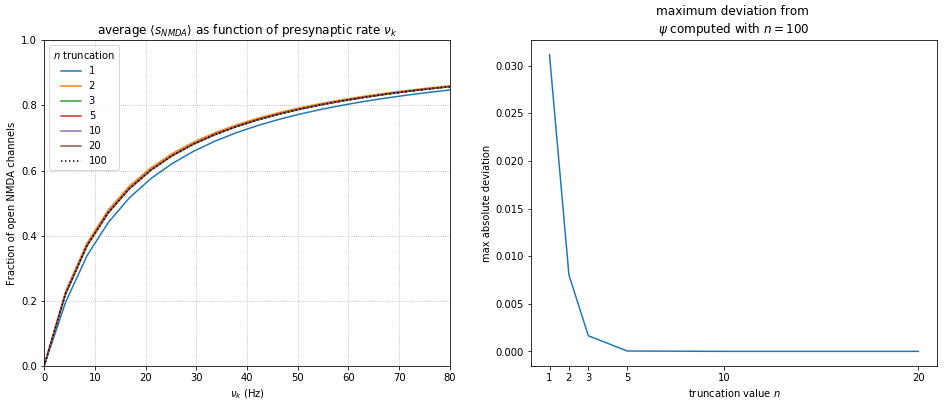

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

max_abs_deviations = []
for n_truncate in truncations:
    s_NMDA_vals = []
    for hz in Hz:
        s_NMDA_vals.append(psi(hz, n_truncate=n_truncate))
    s_NMDA_vals = np.array(s_NMDA_vals)
    max_abs_deviations.append(np.max(
        np.abs(s_NMDA_vals - most_accurate)
    ))
    axes[0].plot(Hz / b2.Hz, s_NMDA_vals, label=n_truncate)
    
axes[0].plot(Hz / b2.Hz, most_accurate, 'k:', label=most_accurate_truncation)
axes[0].grid(ls=':')
axes[0].legend(title='$n$ truncation')
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlim([0.0, 80.0])
axes[0].set_title(r'average $\langle s_{NMDA} \rangle$ as function of presynaptic rate $\nu_k$')
axes[0].set_xlabel(r'$\nu_k$ (Hz)')
axes[0].set_ylabel('Fraction of open NMDA channels')
axes[1].plot(truncations, max_abs_deviations)
axes[1].set_xticks(truncations)
axes[1].set_xlabel('truncation value $n$')
axes[1].set_ylabel('max absolute deviation')
axes[1].set_title(f'maximum deviation from \n$\psi$ computed with $n={most_accurate_truncation}$')
fig.savefig('psi_truncation.png')
plt.show()

Linearising the [Jahr-Stevens formula](https://www.jneurosci.org/content/10/9/3178.short) with the driving force $V(t) - V_E$, given by

$$
\frac{(V(t) - V_E)}{1 + \gamma \exp(-\beta V(t))} =: \frac{(V(t) - V_E)}{J(V)} =: F(V)
$$

around the average membrane potential $\langle V \rangle$ (and writing $V = V(t)$) gives me

$$
\begin{split}
F(V) &\approx F(\langle V \rangle) + \frac{dF(\langle V \rangle)}{dV} (V - \langle V \rangle)\\
&= \frac{\langle V \rangle - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle) \left(\frac{J(\langle V \rangle) + \beta(\langle V \rangle - V_E)(J(\langle V \rangle) - 1)}{J(\langle V \rangle)^2}   \right)\\
&=: \frac{\langle V \rangle - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle) J_2(\langle V \rangle)
\end{split}
$$

This reduces to the formulation in [Brunel and Wang](https://link.springer.com/article/10.1023/A:1011204814320), given by

$$
F(V) \approx \frac{V - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle)\left(\frac{\beta(\langle V \rangle - V_E)(J(\langle V \rangle) - 1)}{J(\langle V \rangle)^2}   \right)
$$

while in the [Feng collection](https://books.google.co.za/books?hl=en&lr=&id=tYwCtQfJfVMC&oi=fnd&pg=PA425&dq=mean-field+theory+of+irregularly+spiking+neurons+brunel+wang+renart&ots=q7bgEVAjnj&sig=bGEEVNgfaJBGbucoGRnJ11Ko3qE&redir_esc=y#v=onepage&q&f=false) the same authors arrive at

$$
F(V) \approx \frac{V - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle) \left(\frac{J(\langle V \rangle) + \beta(\langle V \rangle - V_E)(1 - J(\langle V \rangle))}{J(\langle V \rangle)^2}   \right)
$$

which doesn't seem to fit at all.

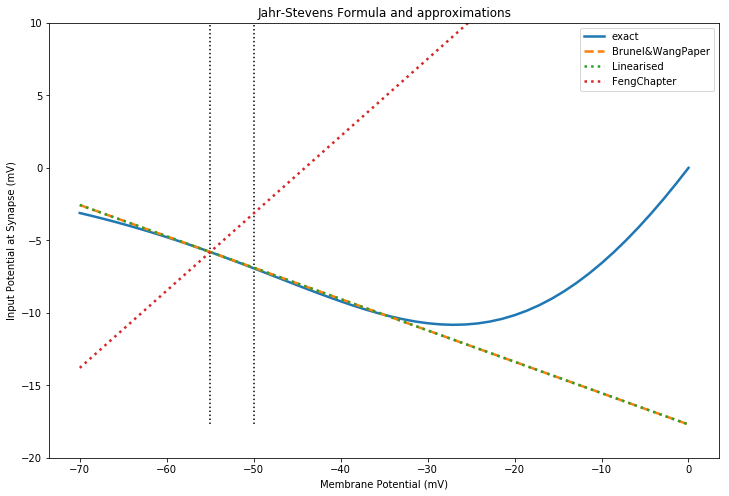

In [5]:
# Jahr-Stevens approximations
def J(V):
    return 1 + gamma_JahrStevens * np.exp(-beta_JahrStevens * V)

def J_2(V):
    J_V = J(V)
    numerator = J_V + beta_JahrStevens * (V - V_E)*(J_V - 1)
    denominator = J_V**2
    return numerator / denominator

def J_2_BrunelWangPaper(V):
    J_V = J(V)
    return beta_JahrStevens * (V - V_E)*(J_V - 1)/(J_V**2)

def J_2_FengChapter(V):
    J_V = J(V)
    numerator = J_V + beta_JahrStevens * (V - V_E)*(1 - J_V)
    denominator = J_V**2
    return numerator / denominator

V = np.linspace(-70*b2.mV, 0*b2.mV, 50)
V_ = -55 * b2.mV
# V_ = -70.39 * b2.mV

g_V = (V - V_E) / J(V)
g_V_linearised = (V_ - V_E) / J(V_) + (V - V_)*J_2(V_)
g_V_BWpaper = (V - V_E) / J(V_) + (V - V_)*J_2_BrunelWangPaper(V_)
g_V_FengCh = (V - V_E) / J(V_) + (V - V_)*J_2_FengChapter(V_)  # wrong

min_g = np.min(np.concatenate([g_V, g_V_linearised, g_V_BWpaper, g_V_FengCh]))
max_g = np.max(np.concatenate([g_V, g_V_linearised, g_V_BWpaper, g_V_FengCh]))

plt.figure(figsize=(12, 8))
plt.plot(V / b2.mV, g_V / b2.mV, label='exact', linewidth=2.5)
plt.plot(V / b2.mV, g_V_BWpaper / b2.mV, label='Brunel&WangPaper', linewidth=2.5, ls='--')
plt.plot(V / b2.mV, g_V_linearised / b2.mV, label='Linearised', linewidth=2.5, ls=':')
plt.plot(V / b2.mV, g_V_FengCh / b2.mV, label='FengChapter', linewidth=2.5, ls=':')
plt.vlines([V_thr  / b2.mV,  V_reset / b2.mV], min_g / b2.mV, max_g / b2.mV, linestyle=':')
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Input Potential at Synapse (mV)')
plt.title("Jahr-Stevens Formula and approximations")
# plt.yticks([])
plt.ylim([-20, 10])
plt.legend()
plt.show()

# plt.savefig('jahrstevens.png')

In [6]:
# g_NMDA = g_NMDA_E
# g_NMDA_eff = g_NMDA * J_2(V_)
# V_E_eff = V_ - (g_NMDA / g_NMDA_eff)*((V_ - V_E)/J(V_))
# V_E_eff, g_NMDA_eff / g_NMDA

In [7]:
# First passage time formula
def siegert_integrand(x):
    return np.exp(x**2)*(1+special.erf(x))

def phi_siegert(
    tau_refrac, tau_m_eff, lower_bound, upper_bound,
    tolerance=1.49e-08, limit=1000
):
    integral, error = integrate.quad(
        siegert_integrand,
        lower_bound,
        upper_bound,
        limit=limit,
        epsabs=tolerance
    )
        
    return (tau_refrac + tau_m_eff * np.sqrt(np.pi) * integral)**-1

WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
 [py.warnings]
WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
 [py.warnings]


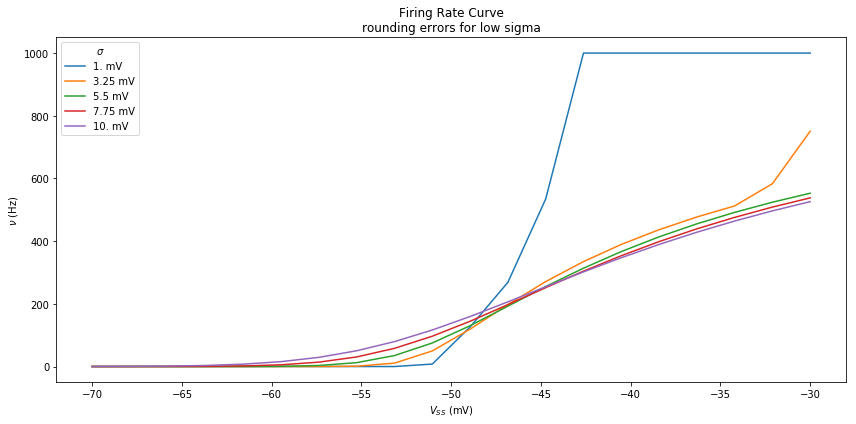

In [8]:
plt.figure(figsize=(12, 6))

tau_m_eff = 3 * b2.ms
b = np.sqrt(tau_AMPA / tau_m_eff)
tau_refrac = 1 * b2.ms
sigma_vals = np.linspace(1, 10, 5) * b2.mV
for sigma in sigma_vals:
    V_SS = np.linspace(-70, -30, 20) * b2.mV
    UB = (V_thr - V_SS)/sigma + 1.03*b
    LB = (V_reset - V_SS)/sigma + 1.03*b
    phi_vals = []
    for lb, ub in zip(LB, UB):
        phi = phi_siegert(
            tau_refrac, tau_m_eff, lb, ub
        )
        phi_vals.append(phi)
    plt.plot(V_SS / b2.mV, phi_vals, label=sigma)
plt.xlabel(r'$V_{SS}$ (mV)')
plt.ylabel(r'$\nu$ (Hz)')
plt.legend(title=r'$\sigma$')
plt.title('Firing Rate Curve\nrounding errors for low sigma')
plt.tight_layout()
plt.show()

In [9]:
# Effective parameters
# def get_g_NMDA_eff(V, g_NMDA_kl):
#     return g_NMDA_kl * J_2(V)

# def get_V_E_eff(V):
#     return V - (1/J_2(V))*(V - V_E)/J(V)

def tau_NMDA_eff(nu):
    return tau_NMDA * (1 - psi(nu))

tau_NMDA_eff(1*b2.Hz)

93.89523446 * msecond

## Plan A

Our Plan A model will work like this:

We will have a $4(p+2)-1$-dimensional dynamical system, where $p$ is the number of selective populations.  
The variables will be (for $k \in \{0, \dots, p, I \}$):
* $\langle s_{NMDA}^k \rangle$ if $k \neq I$, the fraction of open NMDA channels  
* $h^k(t)$, the input potential  
* $\Delta I^k(t)$, the input noise at the external pyramidal synapses
* $\langle V \rangle_k$, the average membrane potential in the population

The firing rates $\nu_k$ are then computed as functions of these parameters at each timestep.  
Implicitly, we assume that $\langle V \rangle_k$ converges to its steady state much faster than the other parameters do. As such, at each timestep we run the dynamics for $\langle V \rangle_k$ to convergence (effectively updating at the same time the "effective" parameters which are all - save one - functions of $\langle V \rangle_k$); then we update all the other parameters a single timestep.

## Plan B

When Plan A fails, we can try work with the simpler model:

1. update $\langle s_{NMDA}^k \rangle$ for $k \in \{0, \dots, p\}$  
2. run until convergence the system of $p+2$ equations:
$$
\tau_m^{k, eff} \frac{d\nu_k}{dt} = -\nu_k + \phi(V_{SS}^k, \sigma_V^{k,eff}, \tau_m^{k,eff})
$$

The reasoning is this: for a given fraction of open NMDA channels at each synapse, all the firing rates depend on each other. The NMDA channels respond much more slowly than the firing rates. The firing rates also depend on $\langle V \rangle_k$ which in turn depend on the firing rates. This simpler model may be used for debugging, and to build up the original model. Beware recursion errors!

## Plan C

When this all fails, we can consider some of the following:
* linearising $J(V)$ around $V = V_{SS}$ and thereby hopefully circumventing the use of $\langle V \rangle$.  
* linearising $J(V)$ around a fixed value, say $V = -52.5 mV$ so that we can circumvent $\langle V \rangle$ and avoid $V_{SS}$ going out of bounds.

In [10]:
# Break on NaNs and numerical error
from collections.abc import Iterable


def check_for_nan_helper(r):
    if isinstance(r, float) or isinstance(r, int):
        if np.isnan(r):
            raise Exception("NaN occurred")
    return "woof"

def check_for_nan(func):
    def new_func(*args, **kwargs):
        result = func(*args, **kwargs)
        if isinstance(result, tuple):
            for r in result:
                check_for_nan_helper(float(r))
        else:
            check_for_nan_helper(float(result))
        return result
    return new_func

In [11]:
class NeuronGroupBase:
    """
    Base class to define methods and parameters available 
    to all neuron populations.
    """
    def __init__(
        self, name, C_k,
        network = None
    ):
        self.name = name
        self.network = network  # used to manage synapses etc
        self.C_k = C_k
        # automatically add to network
        if self.network is not None:
            assert isinstance(self.network, nx.DiGraph), type(self.network)
            self.network.add_node(self)
    
    def __hash__(self):
        return hash(self.name)
    
    def __eq__(self, other):
        if not isinstance(other, type(self)):
            return False
        return other.name == self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
    def s_AMPA_ext(self):
        return None
    
    def s_AMPA(self):
        return None
    
    def s_AMPA(self):
        return None
    
    def s_AMPA(self):
        return None

In [12]:
class NeuronGroup(NeuronGroupBase):
    """
    Dynamic neuron populations, with varying firing rates and 
    average membrane potentials (and effective parameters).
    """
    def __init__(
        self, name,  # unique identifier name
        C_k, C_m, g_m, 
        g_AMPA_ext, g_AMPA, g_NMDA, g_GABA,  # used to determine input current etc, multiplied with presynaptic channel variables
        tau_refrac,
        network = None,
        nu_initial = 3 * b2.Hz,
        V_avg_initial = -52.5 * b2.mV,
        h_initial = -20 * b2.mV
    ):
        super().__init__(
            name=name,
            C_k=C_k,
            network=network
        )
        # constants
        self.C_m = C_m
        self.g_m = g_m
        self.C_k = C_k
        self.g_AMPA_ext = g_AMPA_ext
        self.g_AMPA = g_AMPA
        self.g_NMDA = g_NMDA
        self.g_GABA = g_GABA
        self.tau_refrac = tau_refrac
        
        # dynamic variables
        self.nu_trace = [nu_initial]
        self.DeltaI_trace = [0 * b2.amp]  # Coulombs = b2.second * b2.amp
        self.V_avg_trace = [V_avg_initial]
#         if h_initial is None:  # can't do this until network is complete
#             h_initial = self.mu_C_eff() / self.g_m_eff()
        self.h_trace = [h_initial]
    
    def nu(self):
        return self.nu_trace[-1]
    
    def DeltaI(self):
        return self.DeltaI_trace[-1]
    
    def V_avg(self):
        return self.V_avg_trace[-1]
    
    # using method below raises recursion problems
#     def V_avg(self):
#         nu = self.nu()
#         V_SS = self.V_SS()
#         tau_m_eff = self.tau_m_eff()
#         V_avg = V_SS - (V_thr - V_reset)*nu*tau_m_eff + (V_SS - V_reset)*nu*self.tau_refrac
#         return V_avg
    
    def h(self):
        return self.h_trace[-1]
    
    @check_for_nan
    def g_NMDA_eff(self):
        return self.g_NMDA * J_2(self.V_avg())
    
    @check_for_nan
    def g_m_eff(self):
        value = self.g_m
        for other_group, _, info in self.network.in_edges(self, data=True):
            w_A = info.get('w_A', 1.0)
            w_N = info.get('w_N', 1.0)
            w_I = info.get('w_I', 1.0)
            C_k = other_group.C_k
            
            s_AMPA_ext = other_group.s_AMPA_ext()
            if s_AMPA_ext:
                value += s_AMPA_ext * self.g_AMPA_ext * C_k
                continue
            s_AMPA = other_group.s_AMPA()
            s_NMDA = other_group.s_AMPA()
            if s_AMPA:
                value += s_AMPA * w_A * self.g_AMPA * C_k
                value += s_NMDA * w_N * self.g_NMDA_eff() *  C_k
                continue            
            s_GABA = other_group.s_GABA()
            if s_GABA:
                value += s_GABA * w_I * self.g_GABA * C_k
        return value
    
    @check_for_nan
    def tau_m(self):
        return self.C_m / self.g_m
    
    @check_for_nan
    def tau_m_eff(self):
        return self.C_m / self.g_m_eff()
    
    @check_for_nan
    def V_E_eff(self):
        V_avg = self.V_avg()
        return V_avg - (1/J_2(V_avg))*(V_avg - V_E)/J(V_avg)
    
    @check_for_nan
    def V_SS(self):
        value = self.g_m * V_L
        for other_group, _, info in self.network.in_edges(self, data=True):
            w_A = info.get('w_A', 1.0)
            w_N = info.get('w_N', 1.0)
            w_I = info.get('w_I', 1.0)
            C_k = other_group.C_k
            
            s_AMPA_ext = other_group.s_AMPA_ext()
            if s_AMPA_ext:
                value += s_AMPA_ext * self.g_AMPA_ext * C_k * V_E
                continue
            s_AMPA = other_group.s_AMPA()
            s_NMDA = other_group.s_AMPA()
            if s_AMPA:
                value += s_AMPA * w_A * self.g_AMPA * C_k * V_E
                value += s_NMDA * w_N * self.g_NMDA_eff() *  C_k * self.V_E_eff()
                continue            
            s_GABA = other_group.s_GABA()
            if s_GABA:
                value += s_GABA * w_I * self.g_GABA * C_k * V_I
        g_m_eff = self.g_m_eff()
        return value / g_m_eff
    
    @check_for_nan
    def sigma_C_eff(self):
        value = None
        for other_group, _, info in self.network.in_edges(self, data=True):
            if isinstance(other_group, ExternalGroup):
                C_ext = other_group.C_k
                s_AMPA_ext = other_group.s_AMPA_ext()
                value = np.abs(self.g_AMPA_ext * (self.V_avg() - V_E) * np.sqrt(C_ext * s_AMPA_ext * tau_AMPA))
                break
        return value
    
    # should this be doubled? It effectively doubles the number of external inputs
    @check_for_nan
    def sigma_V_eff(self):
        tau_m_eff = self.tau_m_eff()
        return self.sigma_C_eff() * np.sqrt(tau_m_eff) / self.C_m
    
    @check_for_nan
    def mu_C_eff(self):
        g_m_eff = self.g_m_eff()
        V_SS = self.V_SS()
        g_m = self.g_m
        return V_SS * g_m_eff - V_L * g_m
    
    # TODO: set convergence criterion as distance from steady state, and not distance
    # between successive values
    @check_for_nan
    def compute_new_V_avg_selfconsistently(
        self,
        timeconst=0.1 * b2.ms,
        max_iterations=1000,
        tolerance = 0.001 * b2.mV
    ):
        """Drives V_avg to converge self-consistently to its own definition."""
        return -52.5 * b2.mV
        nu = self.nu()
        # temporarily mutates last value in trace for other methods to access it
        V_avg_original = self.V_avg()
        V_avg_old = V_avg_original
        for i in range(max_iterations):
            V_SS = self.V_SS()
            tau_m_eff = self.tau_m_eff()
#             V_avg_asymptote = V_SS - (V_thr - V_reset)*nu*tau_m_eff + (V_SS - V_reset)*nu*self.tau_refrac
#             dV_avg_Dt = (1/timeconst) * (-V_avg_old + V_avg_asymptote)
            dV_avg_Dt = (1/timeconst) * (-V_avg_old + V_SS - (V_thr - V_reset)*nu*tau_m_eff)
            dV_avg_Dt += (1/timeconst) * (V_SS - V_reset)*nu*self.tau_refrac
            V_avg_new = V_avg_old + defaultdt*dV_avg_Dt
            self.V_avg_trace[-1] = V_avg_new
#             if np.abs(V_avg_new - V_avg_asymptote) < tolerance:
#                 break
            if np.abs(V_avg_new - V_avg_old) < tolerance:
                break
            V_avg_old = V_avg_new
        else:
            print('V_avg did not converge in alotted timesteps')
        self.V_avg_trace[-1] = V_avg_original
        return V_avg_new
    
    @check_for_nan
    def compute_new_DeltaI(self):
        DeltaI_old = self.DeltaI()
        xi = np.random.randn() / np.sqrt(defaultdt)  # Gauss white noise
        sigma_C_eff = self.sigma_C_eff()
        tau_m_eff = self.tau_m_eff()
        dDeltaIDt = (-DeltaI_old + sigma_C_eff*xi) / tau_m_eff
        return DeltaI_old + defaultdt * dDeltaIDt
    
    @check_for_nan
    def compute_new_h(self):
        h_old = self.h()
        tau_m_eff = self.tau_m_eff()
        mu_C_eff = self.mu_C_eff()
        DeltaI = self.DeltaI()
        g_m_eff = self.g_m_eff()
        dtDt = ((1/g_m_eff) * (mu_C_eff + DeltaI) - h_old) / tau_m_eff
        return h_old + defaultdt * dtDt
    
    @check_for_nan
    def V_thr_eff(
        self,
        b=None,
        sigma_V_eff=None
    ):
        a = 1.03
        if b is None:
            tau_m_eff = self.tau_m_eff()
            b = np.sqrt(tau_AMPA / tau_m_eff)
        if sigma_V_eff is None:
            sigma_V_eff = self.sigma_V_eff()
        return V_thr + sigma_V_eff * a * b
    
    @check_for_nan
    def V_reset_eff(
        self,
        b=None,
        sigma_V_eff=None
    ):
        a = 1.03
        if b is None:
            tau_m_eff = self.tau_m_eff()
            b = np.sqrt(tau_AMPA / tau_m_eff)
        if sigma_V_eff is None:
            sigma_V_eff = self.sigma_V_eff()
        return V_reset + sigma_V_eff * a * b
        
    @check_for_nan
    def first_passage_bounds(
        self, tau_m_eff=None
    ):
        if tau_m_eff is None:
            tau_m_eff = self.tau_m_eff()
        g_m_eff = self.g_m_eff()
        g_m = self.g_m
        h = self.h()
        leak_term = V_L * g_m / g_m_eff
        b = np.sqrt(tau_AMPA / tau_m_eff)
        sigma_V_eff = self.sigma_V_eff()
        V_thr_eff = self.V_thr_eff(b=b, sigma_V_eff=sigma_V_eff)
        V_reset_eff = self.V_reset_eff(b=b, sigma_V_eff=sigma_V_eff)
        
        lower_bound = (V_reset_eff - h - leak_term) / sigma_V_eff
        upper_bound = (V_thr_eff - h - leak_term) / sigma_V_eff
        return lower_bound, upper_bound
    
    @check_for_nan
    def first_passage_bounds_Vsteadystate(
        self, tau_m_eff=None
    ):
        if tau_m_eff is None:
            tau_m_eff = self.tau_m_eff()
        g_m_eff = self.g_m_eff()
        g_m = self.g_m
        b = np.sqrt(tau_AMPA / tau_m_eff)
        sigma_V_eff = self.sigma_V_eff()
        V_thr_eff = self.V_thr_eff(b=b, sigma_V_eff=sigma_V_eff)
        V_reset_eff = self.V_reset_eff(b=b, sigma_V_eff=sigma_V_eff)
        V_SS = self.V_SS()
        
        lower_bound = (V_reset_eff - V_SS) / sigma_V_eff
        upper_bound = (V_thr_eff - V_SS) / sigma_V_eff
        return lower_bound, upper_bound
    
    @check_for_nan
    def compute_new_firing_rate(
        self, tolerance=1.49e-08, limit=1000
    ):
        tau_m_eff = self.tau_m_eff()
        lower_bound, upper_bound = self.first_passage_bounds(
            tau_m_eff=tau_m_eff
        )
        rate = phi_siegert(
            self.tau_refrac, tau_m_eff,
            lower_bound, upper_bound,
            tolerance=tolerance, limit=limit
        )
        return rate
    
    @check_for_nan
    def compute_new_firing_rate_Vsteadystate(
        self, tolerance=1.49e-08, limit=1000
    ):
        tau_m_eff = self.tau_m_eff()
        lower_bound, upper_bound = self.first_passage_bounds_Vsteadystate(
            tau_m_eff=tau_m_eff
        )
        rate = phi_siegert(
            self.tau_refrac, tau_m_eff,
            lower_bound, upper_bound,
            tolerance=tolerance, limit=limit
        )
        return rate

In [13]:
class ExternalGroup(NeuronGroupBase):
    def __init__(
        self, name,
        C_k=C_ext, 
        network=None,
        nu=3 * b2.Hz
    ):
        super().__init__(
            name=name,
            C_k=C_k,
            network=network
        )
        self.nu = nu
    
    def s_AMPA_ext(self):
        return self.nu * tau_AMPA

    
class PyramidalGroup(NeuronGroup):
    def __init__(
        self, name,
        C_k,
        C_m=C_m_E,
        g_m=g_m_E,
        g_AMPA_ext=g_AMPA_ext_E,
        g_AMPA=g_AMPA_rec_E,
        g_NMDA=g_NMDA_E,
        g_GABA=g_GABA_E,
        tau_refrac=tau_rp_E,
        network = None,
        nu_initial = 3 * b2.Hz,
        V_avg_initial = -52.5 * b2.mV,
        h_initial = 0 * b2.mV,
        s_NMDA_initial = 0,  # fraction of open channels is determined in the "presynaptic" group
    ):
        super().__init__(
            C_m=C_m, g_m=g_m, C_k=C_k, g_AMPA_ext=g_AMPA_ext,
            g_AMPA=g_AMPA, g_NMDA=g_NMDA, g_GABA=g_GABA,
            tau_refrac=tau_refrac,
            name=name, network=network, nu_initial=nu_initial,
            V_avg_initial=V_avg_initial, h_initial=h_initial
        )
        self.s_NMDA_trace = [s_NMDA_initial]
    
    @check_for_nan
    def s_AMPA(self):
        return self.nu() * tau_AMPA
    
    def s_NMDA(self):
        return self.s_NMDA_trace[-1]
    
    @check_for_nan
    def tau_NMDA_eff(self, psi_nu=None):
        if psi_nu is None:
            psi_nu = psi(self.nu())
        return tau_NMDA * (1 - psi_nu)
    
    @check_for_nan
    def compute_new_s_NMDA(self):
        s_NMDA_old = self.s_NMDA()
        psi_nu = psi(self.nu())
        tau_NMDA_eff = self.tau_NMDA_eff(
            psi_nu=psi_nu
        )
        ds_NMDA_effDt = -(s_NMDA_old - psi_nu)/tau_NMDA_eff
        return s_NMDA_old + defaultdt*ds_NMDA_effDt
        

class InterneuronGroup(NeuronGroup):
    def __init__(
        self, name,
        C_k=N_I,
        C_m=C_m_I,
        g_m=g_m_I,
        g_AMPA_ext=g_AMPA_ext_I,
        g_AMPA=g_AMPA_rec_I,
        g_NMDA=g_NMDA_I,
        g_GABA=g_GABA_I,
        tau_refrac=tau_rp_I,
        network = None,
        nu_initial = 9 * b2.Hz,
        V_avg_initial = -52.5 * b2.mV,
        h_initial = 0 * b2.mV
    ):
        super().__init__(
            C_m=C_m, g_m=g_m, C_k=C_k, g_AMPA_ext=g_AMPA_ext,
            g_AMPA=g_AMPA, g_NMDA=g_NMDA, g_GABA=g_GABA,
            tau_refrac=tau_refrac,
            name=name, network=network, nu_initial=nu_initial,
            V_avg_initial=V_avg_initial, h_initial=h_initial
        )
    
    @check_for_nan
    def s_GABA(self):
        return self.nu() * tau_GABA

In [14]:
class EffectiveParameterTracker:
    """Tracks effective parameters for dynamic neuron groups in network."""
    def __init__(self, network):
        self.network = network
        self.tau_NMDA_eff = {n:[] for n in network.nodes
            if isinstance(n, PyramidalGroup)}
        self.V_reset_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.V_thr_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.mu_C_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.sigma_V_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.sigma_C_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.V_SS = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.V_E_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.tau_m_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.g_m_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.g_NMDA_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.integral_bounds = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
    
    def update(self):
        for n in self.tau_NMDA_eff.keys():
            self.tau_NMDA_eff[n].append(n.tau_NMDA_eff())
        for n in self.V_reset_eff.keys():
            self.V_reset_eff[n].append(n.V_reset_eff())
        for n in self.V_thr_eff.keys():
            self.V_thr_eff[n].append(n.V_thr_eff())
        for n in self.mu_C_eff.keys():
            self.mu_C_eff[n].append(n.mu_C_eff())
        for n in self.sigma_V_eff.keys():
            self.sigma_V_eff[n].append(n.sigma_V_eff())
        for n in self.sigma_C_eff.keys():
            self.sigma_C_eff[n].append(n.sigma_C_eff())
        for n in self.V_SS.keys():
            self.V_SS[n].append(n.V_SS())
        for n in self.V_E_eff.keys():
            self.V_E_eff[n].append(n.V_E_eff())
        for n in self.tau_m_eff.keys():
            self.tau_m_eff[n].append(n.tau_m_eff())
        for n in self.g_m_eff.keys():
            self.g_m_eff[n].append(n.g_m_eff())
        for n in self.g_NMDA_eff.keys():
            self.g_NMDA_eff[n].append(n.g_NMDA_eff())
        for n in self.integral_bounds.keys():
            self.integral_bounds[n].append(n.first_passage_bounds())

In [25]:
def initialise_network():
    net = nx.DiGraph()
    dynamic_neuron_groups = [
        PyramidalGroup(name='nonsel', C_k=N_non, network=net),
        InterneuronGroup(name='inh', C_k=N_I, network=net)
    ]
    for i in range(1,p+1):
        n = PyramidalGroup(name=str(i), C_k=N_sub, network=net)
        dynamic_neuron_groups.append(n)

    for n1 in dynamic_neuron_groups:
        for n2 in dynamic_neuron_groups:
            if isinstance(n1, PyramidalGroup):
                if n1.name == 'nonsel':
                    net.add_edge(n1, n2, w_A=1.0, w_N=1.0)
                elif n1 == n2:
                    net.add_edge(n1, n2, w_A=w_plus, w_N=w_plus)
                else:
                    net.add_edge(n1, n2, w_A=w_minus, w_N=w_minus)
            else:  # is inhibitory group
                net.add_edge(n1, n2, w_I=1.0)

    for n in dynamic_neuron_groups:
        ext = ExternalGroup(name=f'ext-{str(n)}', network=net)
        net.add_edge(ext, n)

    # step 0: reset parameters to steady states
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            n.s_NMDA_trace[0] = psi(n.nu())
    for n in dynamic_neuron_groups:
        n.h_trace[0] = n.mu_C_eff()/n.g_m_eff()
    for n in dynamic_neuron_groups:
        n.V_avg_trace[0] = n.compute_new_V_avg_selfconsistently()
    return net

net = initialise_network()
dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
n = dynamic_neuron_groups[0]

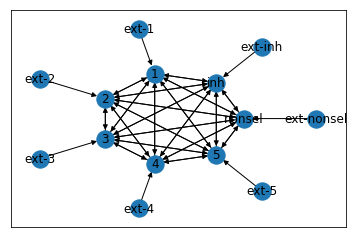

In [26]:
outer = [n for n in net.nodes() if not n in dynamic_neuron_groups]
inner = dynamic_neuron_groups
pos = nx.shell_layout(net, nlist=[inner, outer])
nx.draw_networkx(net, pos=pos)

In [27]:
# this should be zero
n.V_SS() - (n.h() + (n.g_m / n.g_m_eff())*V_L)

0. * volt

In [29]:
# these should be equal
(V_thr - (n.h() + (n.g_m / n.g_m_eff())*V_L)) / (n.sigma_V_eff() * 2),\
(V_thr - n.V_SS()) / (n.sigma_V_eff() * 2)

(1.8160162022517197, 1.8160162022517197)

In [30]:
# n.first_passage_bounds()
ub = (n.V_thr_eff() - n.V_SS())/(n.sigma_V_eff() * 2)
lb = (n.V_reset_eff() - n.V_SS())/(n.sigma_V_eff())
(lb, ub),\
phi_siegert(n.tau_refrac, n.tau_m_eff(), lb, ub)
# phi_siegert(n.tau_refrac, n.tau_m_eff(), lb, ub)

((1.6181835761276053, 2.063260604039084), 2.17064992 * hertz)

In [31]:
n.compute_new_firing_rate(), n.first_passage_bounds(),\
n.compute_new_firing_rate_Vsteadystate(), n.first_passage_bounds_Vsteadystate()

(10.45948224 * uhertz,
 (1.618183576127607, 4.12652120807817),
 10.45948224 * uhertz,
 (1.6181835761276053, 4.126521208078168))

In [33]:
param_tracker = EffectiveParameterTracker(net)
param_tracker.update()

dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]

N_steps = 130  # breaks just after 55 for defaultdt = 0.1 ms

for i in range(N_steps):
    # step 1: compute new average membrane potentials self-consistently
    new_V_avg = {}
    for n in dynamic_neuron_groups:
        new_V_avg[n] = n.compute_new_V_avg_selfconsistently()
    for n in dynamic_neuron_groups:
        n.V_avg_trace.append(new_V_avg[n])

    # step 2: update dynamic values
    # step 2.1: update s_NMDA
    new_s_NMDA = {}
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            new_s_NMDA[n] = n.compute_new_s_NMDA()
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            n.s_NMDA_trace.append(new_s_NMDA[n])
    # step 2.2: update DeltaI
    new_DeltaI = {}
    for n in dynamic_neuron_groups:
        new_DeltaI[n] = n.compute_new_DeltaI()
    for n in dynamic_neuron_groups:
        n.DeltaI_trace.append(new_DeltaI[n])
    # step 2.3: update h
    new_h = {}
    for n in dynamic_neuron_groups:
        new_h[n] = n.compute_new_h()
    for n in dynamic_neuron_groups:
        n.h_trace.append(new_h[n])

    # step 3: compute new firing rates
    new_nu = {}
    for n in dynamic_neuron_groups:
#         new_nu[n] = n.compute_new_firing_rate()
        new_nu[n] = n.compute_new_firing_rate_Vsteadystate()
    for n in dynamic_neuron_groups:
        n.nu_trace.append(new_nu[n])
        
    # debug step: update effective parameter tracker
    param_tracker.update()

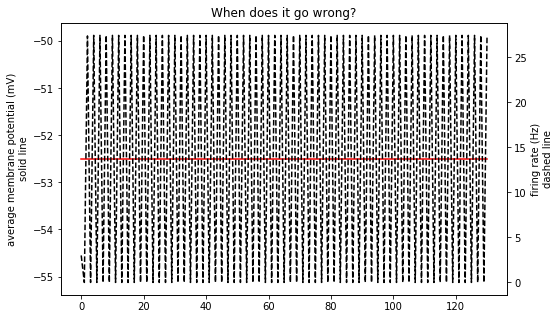

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))

n = dynamic_neuron_groups[0]
ax.plot(np.array(n.V_avg_trace) / b2.mV, 'r')
ax.set_ylabel('average membrane potential (mV)\nsolid line')

ax2 = ax.twinx()
ax2.plot(np.array(n.nu_trace) / b2.Hz, 'k--')
ax2.set_ylabel('firing rate (Hz)\ndashed line')

plt.title('When does it go wrong?')
plt.show()

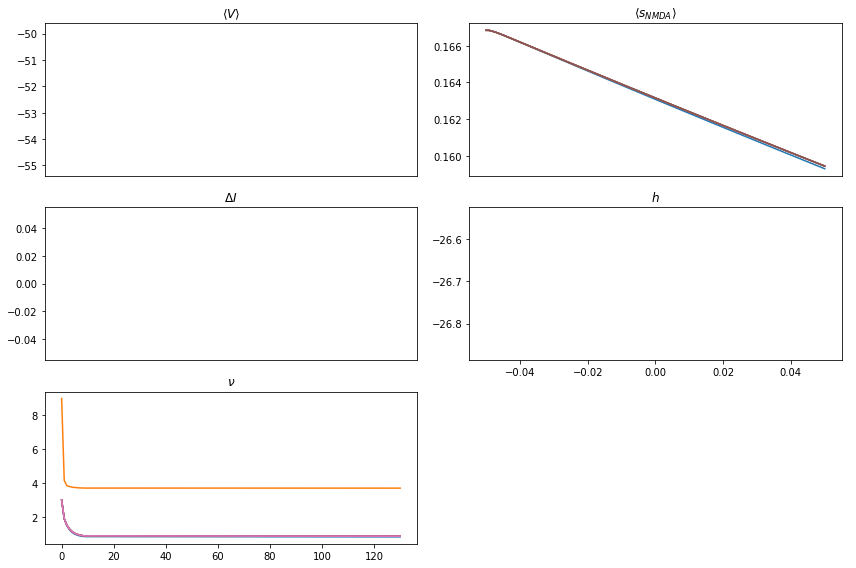

In [50]:
def plot_sim(net):
    dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    for n in dynamic_neuron_groups:
        axes[0,0].plot(np.array(n.V_avg_trace) / b2.mV)
        if isinstance(n, PyramidalGroup):
            axes[0,1].plot(np.array(n.s_NMDA_trace))
        axes[1,0].plot(np.array(n.DeltaI_trace) / b2.amp)
        axes[1,1].plot(np.array(n.h_trace) / b2.mV)
        axes[2,0].plot(np.array(n.nu_trace) / b2.Hz)

    axes[0,0].set_title(r'$\langle V \rangle$')
    axes[0,0].set_xticks([])
    # axes[0,0].set_ylim([-90, -20])

    axes[0,1].set_title(r'$\langle s_{NMDA} \rangle$')
    axes[0,1].set_xticks([])
    axes[1,0].set_title(r'$\Delta I$')
    axes[1,0].set_xticks([])
    axes[1,1].set_title(r'$h$')
    axes[2,0].set_title(r'$\nu$')
    axes[2,1].axis('off')
    fig.tight_layout()
    plt.show()

plot_sim(net)

### Plan A didn't work, so we try a simpler model:

```
for k in pyramidal_neuron_group_indices:
  update s_NMDA_k

# run until convergence:
nu_vec = np.array([n.nu() for n in neuron_groups])
tau_vec = np.array([n.tau_m_eff() for n in neuron_groups])
dnuDt_vec = np.array([-nu_vec[i] + n.phi_siegert() for i,n in enumerate(neuron_groups)])
nu_vec_new = nu_vec + defaultdt * (dnuDt_vec @ tau_vec**-1)

# once converged:
for i, n in enumerate(neuron_groups):
  n.nu_trace.append(nu_vec_new[i])
```
Unfortunately, this raises recursion errors, as `n.g_NMDA_eff()` calls `n.V_avg()` which calls `n.V_SS()` which calls `n.g_NMDA_eff()`. Some refactoring will be necessary.  
Alternatively, setting `n.V_avg()` to return a constant should fix the problem.

In [43]:
b2.get_dimensions(defaultdt*(n.nu() + n.compute_new_firing_rate_Vsteadystate()) * n.tau_m_eff()**-1)

second ** -1

In [44]:
# assert b2.get_dimensions([5 * b2.Hz] * 4 == b2.Hz)
# # works
# assert b2.get_dimensions(np.array([5 * b2.Hz] * 4) == b2.Hz)
# # fails

In [45]:
np.array([0.005 * b2.kHz] * 4)

array([5., 5., 5., 5.])

In [46]:
b2.get_dimensions(np.array([n.compute_new_firing_rate_Vsteadystate() for n in dynamic_neuron_groups]))
# np.array destroys dimensions...

Dimension()

In [51]:
def update_rates_selfconsistently(net, tolerance=0.1*b2.Hz, max_steps=100):
    # add initial rates to new value in trace, for access by effective functions
    dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
    for n in dynamic_neuron_groups:
        n.nu_trace.append(n.nu_trace[-1])
    for iter_ in range(max_steps):
        # compute dynamically incremented rates
        nu_vec = np.array([n.nu() for n in dynamic_neuron_groups])
        tau_vec = np.array([n.tau_m_eff() for n in dynamic_neuron_groups])
        asymptote = np.array([n.compute_new_firing_rate_Vsteadystate() for n in dynamic_neuron_groups])
        dnuDt_vec = (-nu_vec + asymptote) * (tau_vec**-1)
        # workaround to avoid unit loss error
        nu_vec_new = nu_vec + (defaultdt/b2.second) * dnuDt_vec
        # update rates with new values
        for i, n in enumerate(dynamic_neuron_groups):
            n.nu_trace[-1] = nu_vec_new[i] * b2.Hz
        # check for convergence
        diff = np.sqrt( np.sum((asymptote - nu_vec_new)**2))
        if diff*b2.Hz < tolerance:
            break
    else:
        print(f"Firing rates did not converge: diff = {diff} Hz")


In [52]:
net = initialise_network()
param_tracker = EffectiveParameterTracker(net)
param_tracker.update()

N_steps = 130
dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]

N_steps = 130  # breaks just after 55 for defaultdt = 0.1 ms

for i in range(N_steps):
    # step 1: update s_NMDA values
    new_s_NMDA = {}
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            new_s_NMDA[n] = n.compute_new_s_NMDA()
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            n.s_NMDA_trace.append(new_s_NMDA[n])
    # update rates self-consistently
    update_rates_selfconsistently(net)
    param_tracker.update()

Firing rates did not converge: diff = 3.3488750488004646 Hz
Firing rates did not converge: diff = 1.5449268158787532 Hz
Firing rates did not converge: diff = 1.0159109816152012 Hz
Firing rates did not converge: diff = 0.6743793680750224 Hz
Firing rates did not converge: diff = 0.44792117910991236 Hz
Firing rates did not converge: diff = 0.29758322269719906 Hz
Firing rates did not converge: diff = 0.19773441352037 Hz
Firing rates did not converge: diff = 0.1314001475701176 Hz


KeyboardInterrupt: 

### Debugging below...

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# start = N_steps - 20
start = 0
end = len(n.nu_trace)
xaxis = np.arange(start, end) #* defaultdt / b2.ms

for n in param_tracker.tau_NMDA_eff.keys():
    axes[0,0].plot(xaxis, param_tracker.tau_NMDA_eff[n][start:end] / b2.ms)
ax2 = axes[0,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[0,0].set_title(r"$\tau_{NMDA}^{eff}$ (ms)")

for n in param_tracker.V_reset_eff.keys():
    axes[0,1].plot(xaxis, param_tracker.V_reset_eff[n][start:end] / b2.mV)
ax2 = axes[0,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[0,1].set_title(r"$V_{reset}^{eff}$ (mV)")

for n in param_tracker.V_thr_eff.keys():
    axes[0,2].plot(xaxis, param_tracker.V_thr_eff[n][start:end] / b2.mV)
ax2 = axes[0,2].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[0,2].set_title(r"$V_{thr}^{eff}$ (mV)")

for n in param_tracker.mu_C_eff.keys():
    axes[1,0].plot(xaxis, param_tracker.mu_C_eff[n][start:end] / b2.nA)
ax2 = axes[1,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[1,0].set_title(r"$\mu_{C}^{eff}$ (nA)")

for n in param_tracker.sigma_V_eff.keys():
    axes[1,1].plot(xaxis, param_tracker.sigma_V_eff[n][start:end] / b2.mV)
ax2 = axes[1,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[1,1].set_title(r"$\sigma_{V}^{eff}$ (mV)")

for n in param_tracker.sigma_C_eff.keys():
    axes[1,2].plot(xaxis, param_tracker.sigma_C_eff[n][start:end] / (b2.nA * np.sqrt(b2.second)))
ax2 = axes[1,2].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[1,2].set_title(r"$\sigma_{C}^{eff}$ (nA s^0.5)")

for n in param_tracker.V_SS.keys():
    axes[2,0].plot(xaxis, param_tracker.V_SS[n][start:end] / b2.mV)
ax2 = axes[2,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[2,0].set_title(r"$V_{SS}$ (mV)")

for n in param_tracker.V_E_eff.keys():
    axes[2,1].plot(xaxis, param_tracker.V_E_eff[n][start:end] / b2.mV)
ax2 = axes[2,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[2,1].set_title(r"$V_{E}^{eff}$ (mV)")

for n in param_tracker.tau_m_eff.keys():
    axes[2,2].plot(xaxis, param_tracker.tau_m_eff[n][start:end] / b2.ms)
ax2 = axes[2,2].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[2,2].set_title(r"$\tau_{m}^{eff}$ (ms)")

for n in param_tracker.g_m_eff.keys():
    axes[3,0].plot(xaxis, param_tracker.g_m_eff[n][start:end] / b2.nS)
ax2 = axes[3,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[3,0].set_title(r"$g_{m}^{eff}$ (nS)")

for n in param_tracker.g_NMDA_eff.keys():
    axes[3,1].plot(xaxis, param_tracker.g_NMDA_eff[n][start:end] / b2.nS)
ax2 = axes[3,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[3,1].set_title(r"$g_{NMDA}^{eff}$ (nS)")

for n in param_tracker.integral_bounds.keys():
    lower = [x[0] for x in param_tracker.integral_bounds[n][start:end]]
    upper = [x[1] for x in param_tracker.integral_bounds[n][start:end]]
    axes[3,2].plot(xaxis, lower, label="lower")
    axes[3,2].plot(xaxis, lower, label="upper")
    break
axes[3,2].legend()

# for n in dynamic_neuron_groups:
#     upper, lower = 
#     ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
# axes[3,2].set_title(r"Integral bounds")

# axes[3,2].axis("off")

fig.tight_layout()

plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(upper)) 
plt.plot(np.array(lower))
plt.grid()

In [ ]:
np.min(np.abs(np.array(upper) - np.array(lower))[:-9])

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(upper) - np.array(lower))
plt.grid()

In [ ]:
np.sign(n.g_AMPA * (V_reset - V_E)) == np.sign(n.g_NMDA_eff() * (V_reset - n.V_E_eff()))

In [ ]:
# cf. pg 449, these values are finall correct!
n.V_avg_trace[0] = -55*b2.mV
print(f"{n.g_NMDA_eff() / n.g_NMDA} ~ 0.22", f"{n.V_E_eff() / b2.mV} ~ -81.8", sep='\n')

In [ ]:
n.sigma_C_eff() / np.sqrt(b2.second)

In [ ]:
print("<s_NMDA>:", n.s_NMDA(), "--->", n.compute_new_s_NMDA())
print("DeltaI:  ", n.DeltaI(), "--->", n.compute_new_DeltaI())
print("h:       ", n.h(), "--->", n.compute_new_h())

In [ ]:
n.C_m = 0.25 * b2.nF
n.C_m

In [ ]:
n.g_NMDA_eff(), n.g_NMDA

In [ ]:
n.g_NMDA_eff() * (V_ - n.V_E_eff())

In [ ]:
n.g_m, n.g_m_eff()

In [ ]:
n.tau_m(), n.tau_m_eff()

In [ ]:
n.nu(),\
n.g_m_eff() / n.g_m,\
n.tau_m() / n.tau_m_eff()

In [ ]:
for n in dynamic_neuron_groups:
    print(n.nu(), n.compute_new_firing_rate())
    print(n.V_avg(), n.compute_new_V_avg_selfconsistently())